In [1]:
from qiskit import IBMQ
#import qiskit.tools.jupyter
#%qiskit_job_watcher

import numpy as np
import qutip as qt
import matplotlib.pyplot as plt
%matplotlib inline

IBMQ.load_account()
provider = IBMQ.get_provider(group='open')
backend = provider.get_backend(open_pulse=True)

In [2]:
def to_ptm(op):
    paulis = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
    ptm = np.zeros((4, 4), dtype=complex)
    for i in range(4):
        for j in range(4):
            ptm[i, j] = (paulis[i] * op * paulis[j] * op.dag()).tr()/2
    return qt.Qobj(ptm)

def rotation(theta, phi, lam):
    U = [[np.cos(theta/2), -np.exp(1j*lam) * np.sin(theta/2)], 
         [np.exp(1j*phi) * np.sin(theta/2), np.exp(1j*lam+1j*phi) * np.cos(theta/2)]]
    return qt.Qobj(U)

def objective(angles, *args):
    theta, phi, lam = angles
    U = to_ptm(rotation(theta, phi, lam))
    G, G_ideal = args
    norm = np.linalg.norm((G_ideal - U * G)) ** 2
    return norm

In [3]:
from qiskit.circuit import QuantumRegister, QuantumCircuit
from qiskit.ignis.verification.tomography import process_tomography_circuits
from qiskit.execute import execute

register = QuantumRegister(1)
circuit = QuantumCircuit(register)
circuit.h(0)

experiments = process_tomography_circuits(circuit, register[0])
job = backend.retrieve_job('5e55c31d45520e0018ffab00')
result = job.result()

print(job.job_id())

5e55c31d45520e0018ffab00


CP? True. TP? True.
Norm from ideal: 0.029602687499999402.


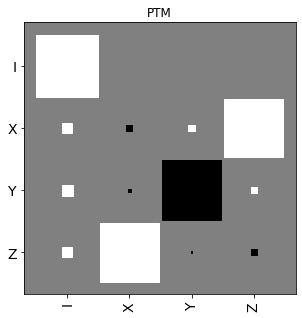

In [4]:
from qiskit.ignis.verification.tomography import ProcessTomographyFitter
from qiskit.quantum_info import PTM
from qiskit.visualization import plot_state_hinton

tomography = ProcessTomographyFitter(result, experiments)
choi = tomography.fit()
ptm = qt.Qobj(PTM(choi).data)

ptm_ideal = to_ptm(qt.hadamard_transform(1))
ptm_norm_before =  np.linalg.norm((ptm_ideal - ptm).full()) ** 2

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_state_hinton(ptm.dag(), ax_real=ax)
ax.set_title(r'PTM');
ax.set_xticklabels(['I', 'X', 'Y', 'Z'])
ax.set_yticklabels(['I', 'X', 'Y', 'Z'])

print('CP? '+str(PTM(choi).is_cp())+'.', 'TP? '+str(PTM(choi).is_tp())+'.')
print('Norm from ideal: '+str(ptm_norm_before)+'.')

In [5]:
theta_list = np.linspace(-np.pi, np.pi, 101)
phi_list = np.linspace(-np.pi, np.pi, 101)

V = np.zeros((len(theta_list), len(phi_list)))
for i, theta in enumerate(theta_list):
    for j, phi in enumerate(phi_list):
        angles = phi, theta, 0
        V[i, j] = objective(angles, ptm, ptm_ideal)

0.029602687499999402

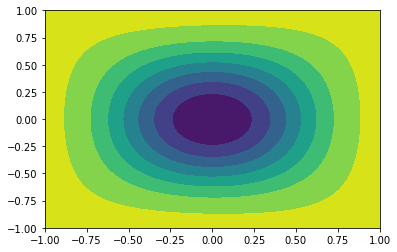

In [6]:
plt.contourf(theta_list/np.pi, phi_list/np.pi, V)
np.min(V)

In [7]:
theta_list = np.linspace(-np.pi/2000, np.pi/2000, 101)
phi_list = np.linspace(-np.pi/2000, np.pi/2000, 101)

V_zoom = np.zeros((len(theta_list), len(phi_list)))
for i, theta in enumerate(theta_list):
    for j, phi in enumerate(phi_list):
        angles = phi, theta, 0
        V_zoom[i, j] = objective(angles, ptm, ptm_ideal)

0.02954268718993431

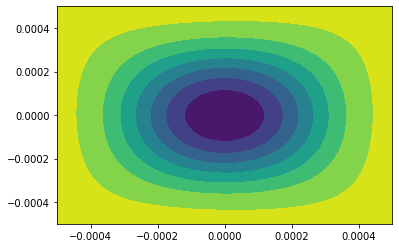

In [8]:
plt.contourf(theta_list/np.pi, phi_list/np.pi, V)
np.min(V_zoom)

In [9]:
ptm = to_ptm(rotation(np.pi/2-0.01, 0.04, np.pi+0.003))
ptm_ideal = to_ptm(rotation(np.pi/2, 0, np.pi))

[ 0.00332325  0.09277053 -0.1055077 ]
Norm from ideal correction: 2.137362374242874e-16.


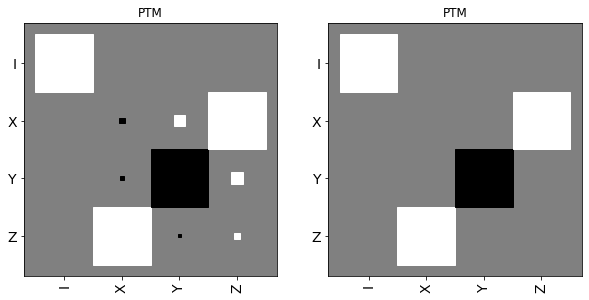

In [10]:
from scipy.optimize import minimize
guess = .5 * np.random.randn(3, 1) 
#bounds = ((np.pi/2, np.pi/2), (np.pi/2, np.pi/2), (np.pi/2, np.pi/2))
solution = minimize(objective, guess, args=(ptm, ptm_ideal), tol=1e-12)
angles = solution.x

theta, phi, lam = angles
U = to_ptm(rotation(theta, phi, lam))

ptm_corr = U * ptm
ptm_norm_after =  np.linalg.norm((ptm_corr - ptm_ideal).full()) **2

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
plot_state_hinton(ptm.dag(), ax_real=axs[0])
plot_state_hinton(ptm_corr.dag(), ax_real=axs[1])
for ax in axs:
    ax.set_title(r'PTM');
    ax.set_xticklabels(['I', 'X', 'Y', 'Z'])
    ax.set_yticklabels(['I', 'X', 'Y', 'Z'])

print(angles/np.pi)
print('Norm from ideal correction: '+str(ptm_norm_after)+'.')

In [85]:
rotation(theta, phi, lam).dag()

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.99998638+0.j          0.00499998-0.00149994j]
 [-0.00493597-0.00169876j  0.99918589+0.04000378j]]

In [86]:
rotation(-theta, -lam, -phi)

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[ 0.99998638+0.j          0.00499998-0.00149994j]
 [-0.00493597-0.00169876j  0.99918589+0.04000378j]]